In [1]:
import pandas as pd
import datetime as dt
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import levene
import seaborn as sns # for prettier plots
#Time series
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# import warnings
# warnings.filterwarnings('ignore')

In [83]:
start = dt.datetime(1990,1,1)
end = dt.datetime(2023,6,30)
etf = 'SPY'
data = yf.download(etf, start)['Adj Close']
data = pd.DataFrame(data)
data = np.log(data['Adj Close']/(data['Adj Close']).shift(1))
data_m = data


[*********************100%***********************]  1 of 1 completed


In [14]:
#Resampleo a anual

# data_m = data.resample('Y').apply(lambda x:x.iloc[-1])
data_m = data.resample('M').apply(lambda x:x.iloc[-1])
data_m = pd.DataFrame(data_m)
data_m = data_m.dropna()


In [4]:
# data_m = data_m.fillna(method = 'ffill')
# data_m = data_m.replace([np.inf, -np.inf], np.nan)
# data_m = data_m.dropna()  # Drop NaN values

Ahora vemos como queda el gráfico de frecuencia de retornos logarítmicos

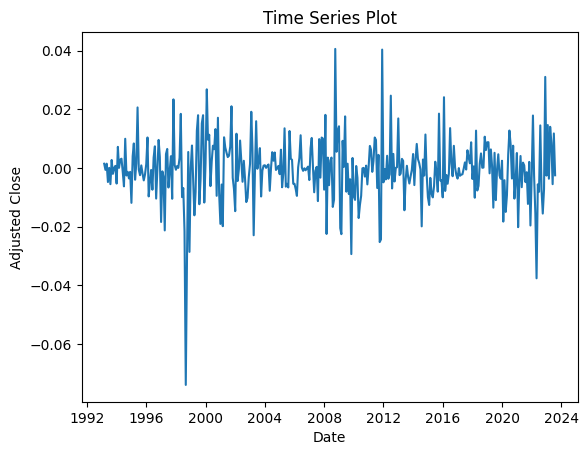

In [21]:
plt.plot(data_m)

plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Adjusted Close')

plt.show()

In [6]:
# pd.set_option('display.max_rows', None)
# data_m

In [7]:
# Perform Augmented Dickey-Fuller test
result = adfuller(data_m)

# Extract and print the test statistics and p-value
adf_statistic = result[0]
p_value = result[1]
print(f'ADF Statistic: {adf_statistic:.4f}')
print(f'p-value: {p_value:.4f}')

# Compare the p-value to the significance level (e.g., 0.05) for interpretation
if p_value < 0.05:
    print('The time series is likely stationary.')
else:
    print('The time series is likely non-stationary.')

ADF Statistic: -7.4720
p-value: 0.0000
The time series is likely stationary.


In [8]:
def test_stationarity(timeseries):

    #Perform Dickey Fuller Test
    print("Results of the ADF")
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(data_m)

Results of the ADF
Test Statistic                -7.472015e+00
p-value                        5.025873e-11
#Lags Used                     0.000000e+00
Number of Observations Used    6.000000e+01
Critical Value (1%)           -3.544369e+00
Critical Value (5%)           -2.911073e+00
Critical Value (10%)          -2.593190e+00
dtype: float64


In [9]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh', title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5, method='ywm')  # Set method to 'ywm'
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

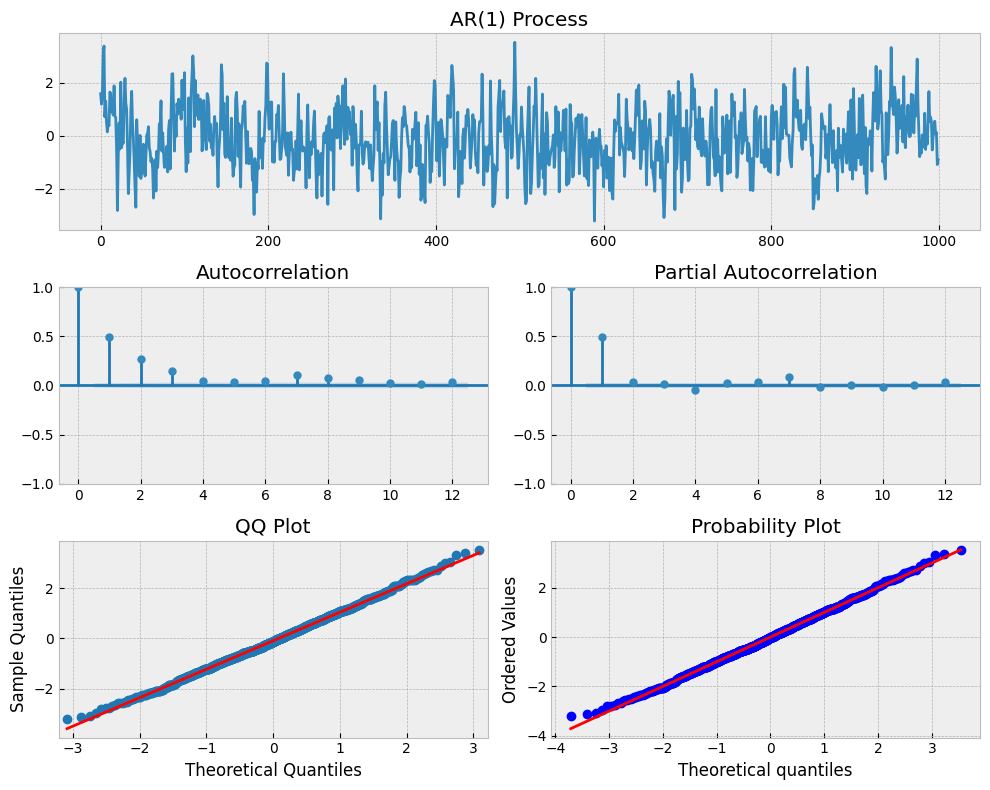

In [10]:
#Simulate an AR(1)
np.random.seed(0)
n_samples = 1000
a = 0.5
x = w = np.random.normal(size = n_samples)
for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]

limit = 12
_ = tsplot(x, lags = limit, title = "AR(1) Process")
    

AR(2) process

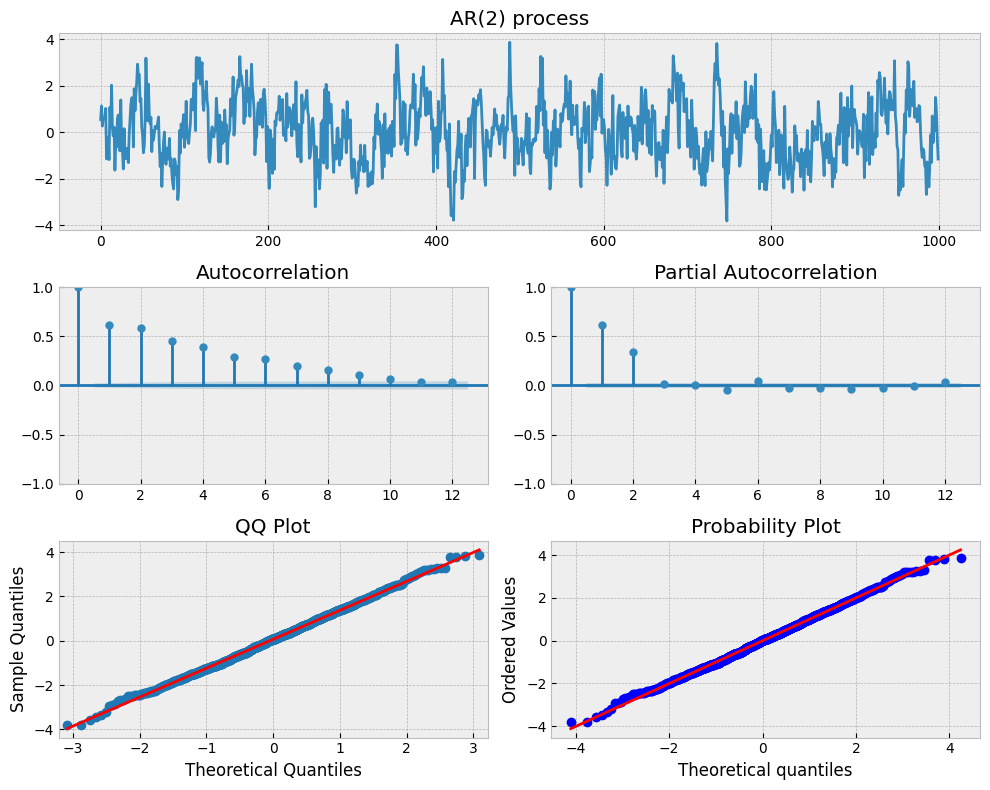

In [11]:
n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="AR(2) process")
plt.show()


MA(1)

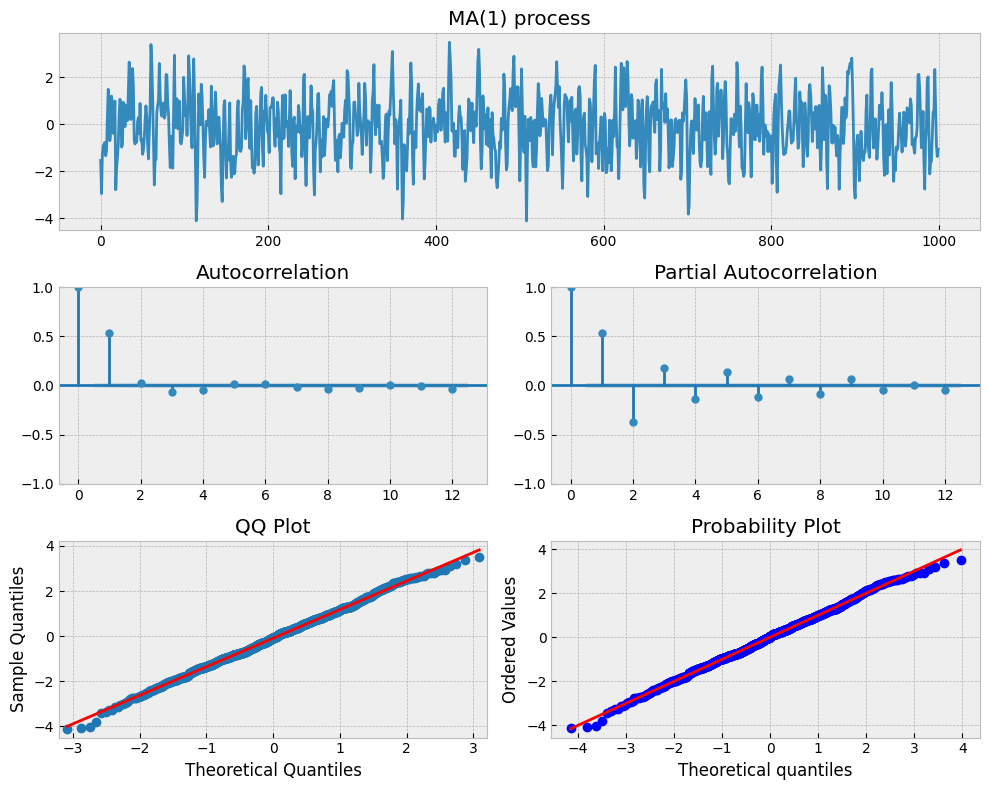

In [12]:
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=12
_ = tsplot(ma1, lags=limit,title="MA(1) process")
plt.show()

MA(2)

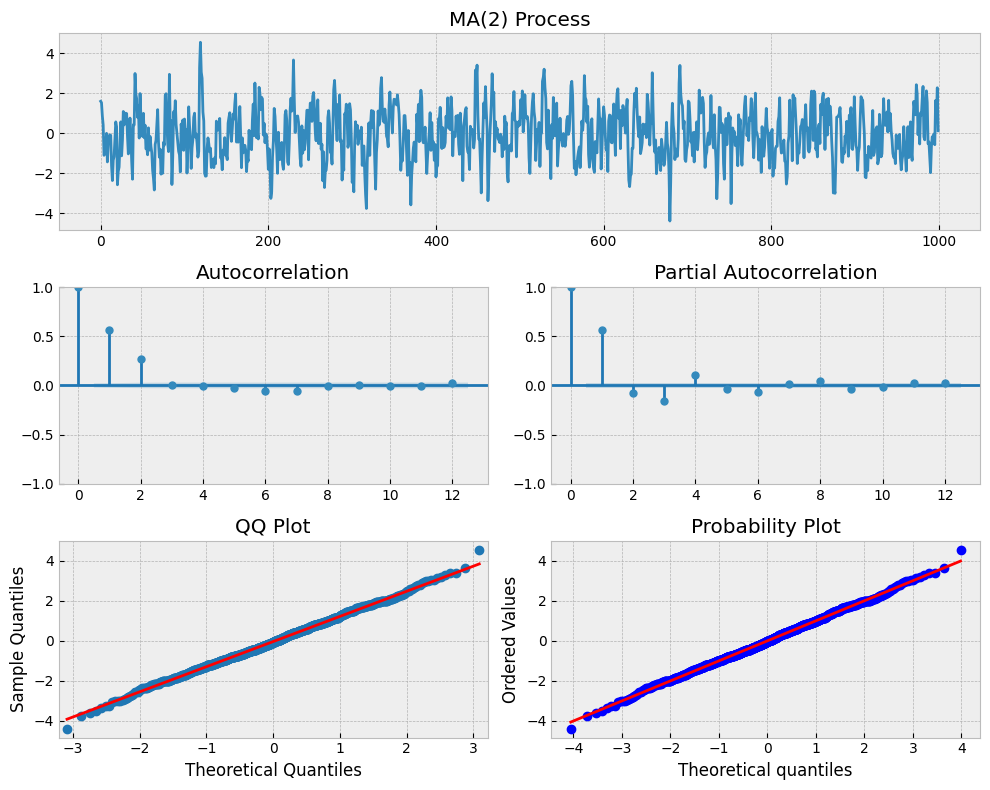

In [13]:
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6,0.4])
ar = np.r_[1,-alphas]
ma = np.r_[1,betas]

ma3 = smt.arma_generate_sample(ar = ar, ma = ma, nsample = n)
_ = tsplot(ma3, lags = 12, title = "MA(2) Process")
plt.show()

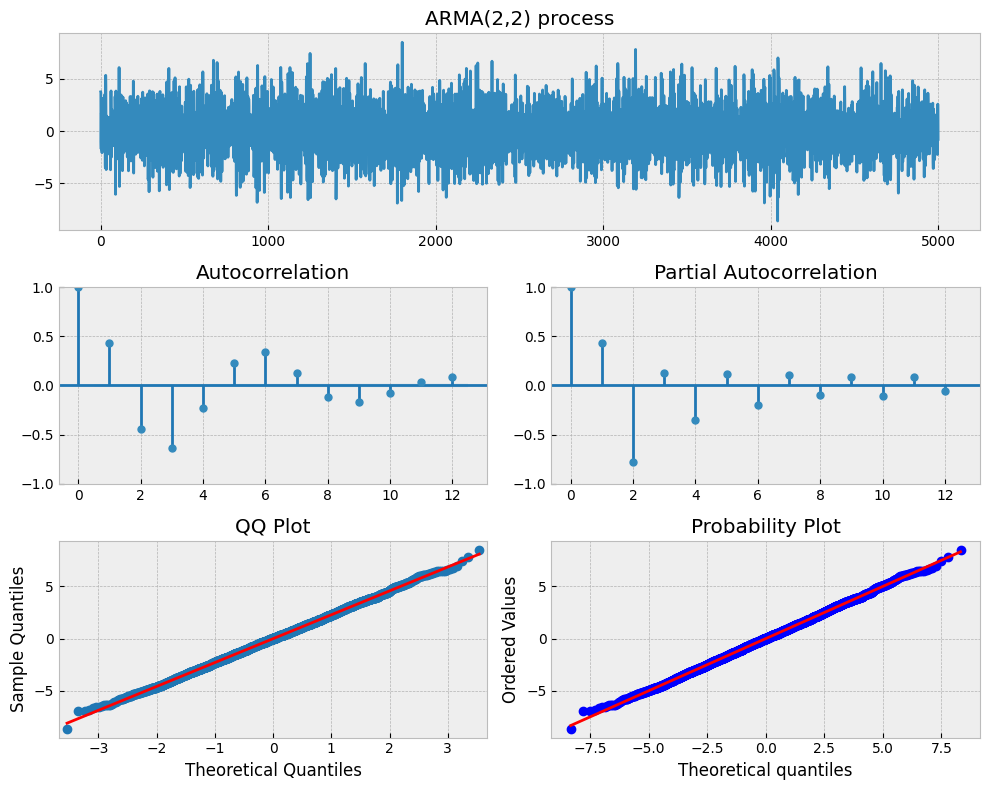

In [18]:

max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/5) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")
plt.show()


In [31]:
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))        

aic:    inf | order: None


In [7]:
from prophet import Prophet
from prophet.plot import plot

In [84]:
data_m = data_m.reset_index()
data_m = data_m.rename(columns={'Date':'ds','Adj Close':'y'})

In [88]:
holidays = pd.DataFrame({
    'holiday': 'US Holidays',
    'ds': pd.to_datetime(['2023-07-04',  # Include July 4th and other holidays if needed
                         ]),
    'lower_window': 0,
    'upper_window': 0
})
m = Prophet(holidays = holidays)
# weekends = pd.date_range(start='1990-1-1', end='2023-06-30', freq='W-SAT').union(pd.date_range(start='1990-1-1', end='2023-06-30', freq='W-SUN'))
m.fit(data_m)
future = m.make_future_dataframe(periods = 11, freq = 'B')
# future = future[~future['ds'].isin(weekends)]
forecast = m.predict(future)
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast.tail(11)

14:38:20 - cmdstanpy - INFO - Chain [1] start processing
14:38:24 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
7659,2023-06-30,0.000656,-0.013534,0.015917
7660,2023-07-03,0.000984,-0.014550,0.016458
7661,2023-07-04,0.001413,-0.013356,0.016761
7662,2023-07-05,0.001249,-0.012467,0.015914
7663,2023-07-06,0.000983,-0.014874,0.016392
7664,2023-07-07,0.001105,-0.013531,0.016972
7665,2023-07-10,0.001110,-0.013230,0.016846
7666,2023-07-11,0.001427,-0.013386,0.016806
7667,2023-07-12,0.001153,-0.014320,0.016593
7668,2023-07-13,0.000783,-0.014141,0.015929


In [95]:
data2_m = yf.download('SPY', start = '2023-6-29', end = '2023-7-15')['Adj Close']
data2_m = pd.DataFrame(data2_m)
data2_m = np.log(data2_m['Adj Close']/(data2_m['Adj Close']).shift(1)).dropna()

[*********************100%***********************]  1 of 1 completed


In [96]:
data2_m = data2_m.reset_index()
data2_m

,Date,Adj Close
0,2023-06-30,0.011732
1,2023-07-03,0.001150
2,2023-07-05,-0.001488
3,2023-07-06,-0.007861
4,2023-07-07,-0.002528
5,2023-07-10,0.002528
6,2023-07-11,0.006348
7,2023-07-12,0.008014
8,2023-07-13,0.007906
9,2023-07-14,-0.000623


In [97]:
forecast = forecast.merge(data2_m[['Date', 'Adj Close']], left_on='ds', right_on='Date', how='left')

# Drop the duplicate 'Date' column that resulted from the merge
forecast.drop(columns=['Date'], inplace=True)

# Rename the 'Adj Close' column to 'Real'
forecast.rename(columns={'Adj Close': 'Real'}, inplace=True)

# Display the last few rows of the updated 'forecast' DataFrame
print(forecast.tail(6))

          ds      yhat  yhat_lower  yhat_upper      Real      Real
3 2023-06-29  0.000441   -0.014281    0.016704       NaN       NaN
4 2023-06-30  0.000656   -0.013375    0.015689  0.011732  0.011732
5 2023-07-03  0.000984   -0.015310    0.016688  0.001150  0.001150
6 2023-07-04  0.001413   -0.014385    0.016191       NaN       NaN
7 2023-07-05  0.001249   -0.013055    0.016496 -0.001488 -0.001488
8 2023-07-06  0.000983   -0.014067    0.016756 -0.007861 -0.007861


In [94]:
# forecast = forecast.loc[:,~forecast.columns.duplicated()]
forecast = forecast.tail(9)
forecast

,ds,yhat,yhat_lower,yhat_upper,Real
7655,2023-06-26,0.000238,-0.013649,0.016394,NaN
7656,2023-06-27,0.000720,-0.013963,0.015816,NaN
7657,2023-06-28,0.000625,-0.014814,0.015040,NaN
7658,2023-06-29,0.000441,-0.014281,0.016704,NaN
7659,2023-06-30,0.000656,-0.013375,0.015689,0.011732
7660,2023-07-03,0.000984,-0.015310,0.016688,0.001150
7661,2023-07-04,0.001413,-0.014385,0.016191,NaN
7662,2023-07-05,0.001249,-0.013055,0.016496,-0.001488
7663,2023-07-06,0.000983,-0.014067,0.016756,-0.007861


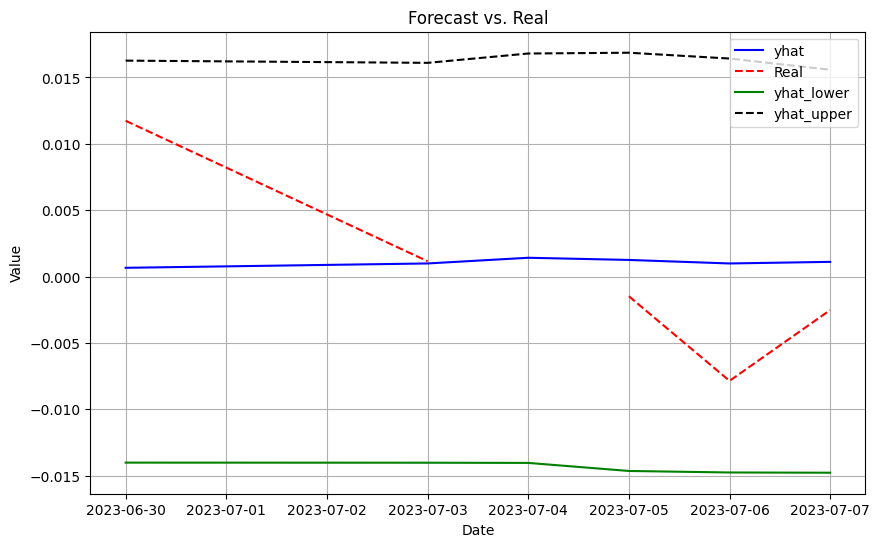

In [73]:
forecast['ds'] = pd.to_datetime(forecast['ds'])
plt.figure(figsize=(10, 6))
plt.plot(forecast['ds'], forecast['yhat'], label='yhat', color='blue')
plt.plot(forecast['ds'], forecast['Real'], label='Real', color='red', linestyle='dashed')
plt.plot(forecast['ds'], forecast['yhat_lower'], label='yhat_lower', color='green')
plt.plot(forecast['ds'], forecast['yhat_upper'], label='yhat_upper', color='black', linestyle='dashed')
# plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.3, color='blue')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast vs. Real')
plt.legend()
plt.grid(True)
plt.show()

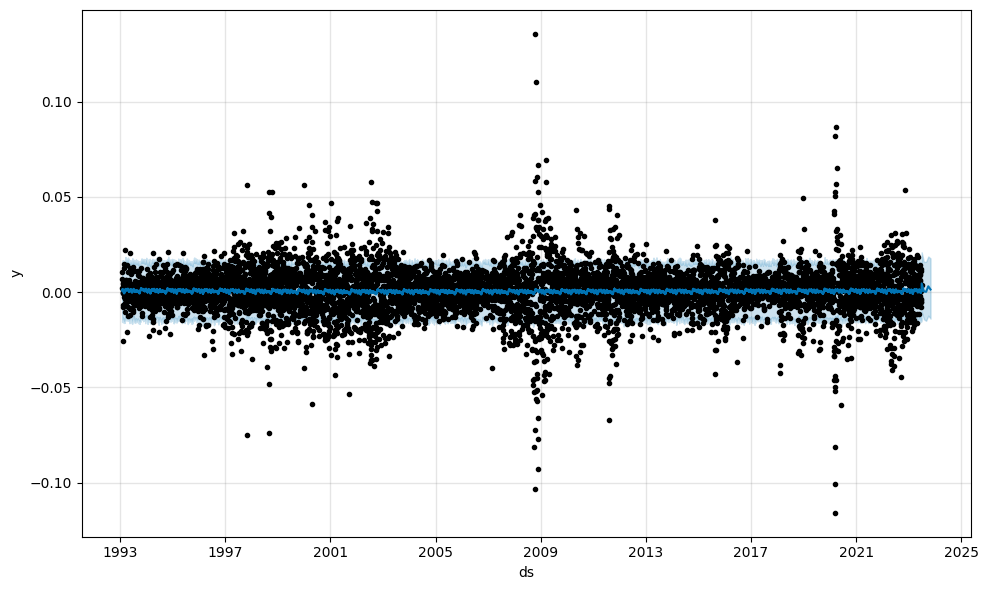

In [11]:
fig = plot(m,forecast)
plt.show()